In [27]:
import sys
import os
sys.path.append('..')


# Setup model

In [28]:
import torch
from comic_ocr.models import recognition, localization
from comic_ocr.utils import get_path_project_dir
from comic_ocr.utils.pytorch_model import get_total_parameters_count
from comic_ocr.models import train_helpers


model_name = 'recognition_crnn_small'
model_path = get_path_project_dir(f'data/output/models/{model_name}.bin')

from comic_ocr.models.recognition.crnn.crnn import CRNN
model = CRNN.create_small_model()
# model = recognition.load_model(model_path)

save_model_callback = train_helpers.callback_to_save_model_on_increasing_metric(model, model_path, 'perfect_match_accuracy')
# save_model_callback = lambda x: return None

In [29]:
print('- preferred_image_size:', model.preferred_image_height)
print('- get_total_parameters_count', get_total_parameters_count(model))


- preferred_image_size: 24
- get_total_parameters_count 482001


# Prepare Dataset

In [30]:
from comic_ocr.utils.plotting import show_images

dataset_example 40


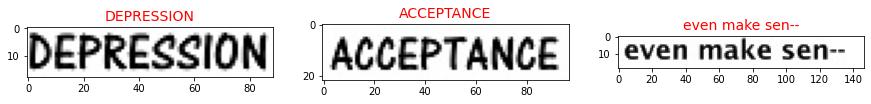

In [31]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = recognition.RecognitionDataset.load_annotated_dataset(dataset_example_path)
print('dataset_example', len(dataset_example))

show_images(
    [dataset_example.get_line_image(0), dataset_example.get_line_image(1), dataset_example.get_line_image(-1)],
    [dataset_example.get_line_text(0), dataset_example.get_line_text(1), dataset_example.get_line_text(-1)],
) 

generated_dataset 3681


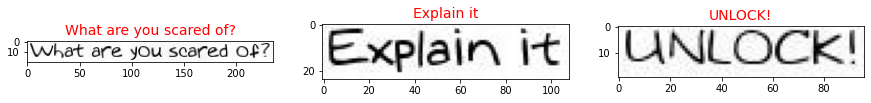

In [32]:
dataset_generated_path = get_path_project_dir('data/output/generate_manga_dataset')
dataset_generated = recognition.RecognitionDataset.load_generated_dataset(dataset_generated_path)
print('generated_dataset', len(dataset_generated))


show_images(
    [dataset_generated.get_line_image(0), dataset_generated.get_line_image(1), dataset_generated.get_line_image(-1)],
    [dataset_generated.get_line_text(0), dataset_generated.get_line_text(1), dataset_generated.get_line_text(-1)],
) 

dataset_generated_lines 1000


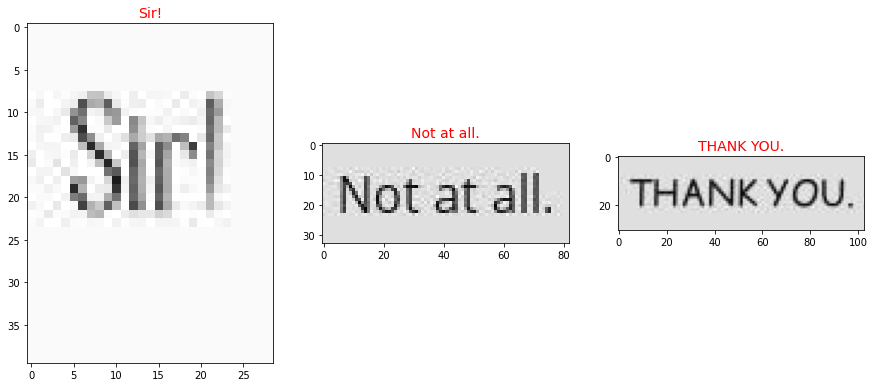

In [33]:
dataset_generated_lines_path = get_path_project_dir('data/output/generate_single_line_dataset')
dataset_generated_lines = recognition.RecognitionDataset.load_generated_single_line_dataset(dataset_generated_lines_path)
print('dataset_generated_lines', len(dataset_generated_lines))


show_images(
    [dataset_generated_lines.get_line_image(0), dataset_generated_lines.get_line_image(1), dataset_generated_lines.get_line_image(-1)],
    [dataset_generated_lines.get_line_text(0), dataset_generated_lines.get_line_text(1), dataset_generated_lines.get_line_text(-1)],
) 

dataset_annotated 824


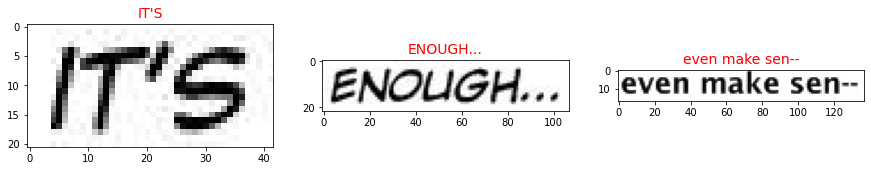

In [34]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = recognition.RecognitionDataset.load_annotated_dataset(dataset_annotated_path)
print('dataset_annotated', len(dataset_annotated))

show_images(
    [dataset_annotated.get_line_image(0), dataset_annotated.get_line_image(1), dataset_annotated.get_line_image(-1)],
    [dataset_annotated.get_line_text(0), dataset_annotated.get_line_text(1), dataset_annotated.get_line_text(-1)],
) 

### Create Dataset with Localization Model

dataset_annotated 806


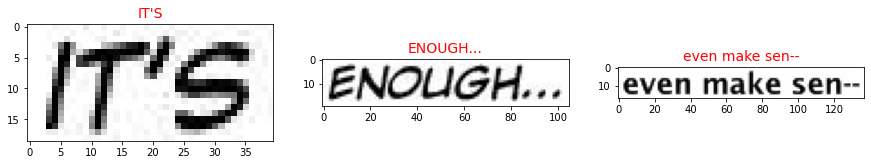

In [35]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')

localization_model = localization.load_model()
dataset_localized = recognition.RecognitionDataset.create_localized_dataset(
    dataset_annotated_path, localization_model, include_false_predictions=False, include_missed_annotations=False)

print('dataset_annotated', len(dataset_localized))

show_images(
    [dataset_localized.get_line_image(0), dataset_localized.get_line_image(1), dataset_localized.get_line_image(-1)],
    [dataset_localized.get_line_text(0), dataset_localized.get_line_text(1), dataset_localized.get_line_text(-1)],
) 

In [36]:
# negative_example_indexes = [i for i in range(len(localized_dataset)) if localized_dataset.get_line_text(i) == None]
# print('negative_example_indexes', len(negative_example_indexes))

# show_images(
#     [localized_dataset.get_line_image(negative_example_indexes[0]), 
#      localized_dataset.get_line_image(negative_example_indexes[1]), 
#      localized_dataset.get_line_image(negative_example_indexes[-1])],
#     [localized_dataset.get_line_text(negative_example_indexes[0]), 
#      localized_dataset.get_line_text(negative_example_indexes[1]), 
#      localized_dataset.get_line_text(negative_example_indexes[-1])],
# ) 

## Train/Validation Datasets

In [37]:
import random
random.seed('abc')


dataset_annotated = dataset_annotated.shuffle()
dataset_generated = dataset_generated.shuffle()
dataset_generated_lines = dataset_generated_lines.shuffle()
dataset_example = dataset_example.shuffle()

# Validation Dataset (annotated + example)
validation_dataset = recognition.RecognitionDataset.merge(
    dataset_example,
    dataset_annotated.subset(to_idx=400)
).shuffle()


# Training Dataset (generated + annotated + example)
final_training_dataset = recognition.RecognitionDataset.merge(
    dataset_example,
    dataset_annotated.subset(from_idx=400),
)

training_dataset = recognition.RecognitionDataset.merge(
    final_training_dataset.repeat(10),
    dataset_generated.subset(from_idx=0, to_idx=4000),
)
training_dataset = recognition.RecognitionDataset.merge(
    training_dataset,
    dataset_generated_lines,
)
training_dataset = recognition.RecognitionDatasetWithAugmentation.of_dataset(
    training_dataset, 
    batch_height=model.preferred_image_height, 
    choices_padding_width=(0, 0, 0, 0, 2, 4, 6, -2),
    choices_padding_height=(0, 0, 0, 1, 2, 2, 3, 4, 4, 6)
)


print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))
print('final_training_dataset', len(final_training_dataset))

validation_dataset 440
training_dataset 9321
final_training_dataset 464


# Training

In [38]:
from comic_ocr.models import train_helpers
from comic_ocr.models.recognition import train
from comic_ocr.utils.plotting import plot_losses, plot_metrics, show_images
from torch import optim
from IPython.display import clear_output

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')



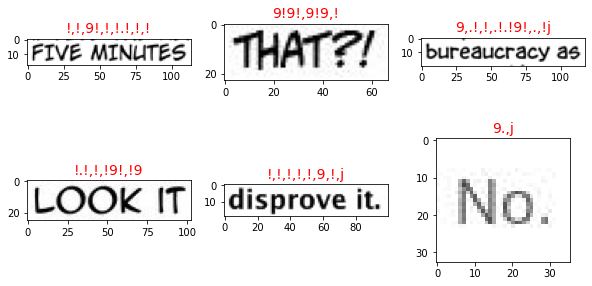

In [39]:

def show_example(model, images):
    outputs = [model.recognize(img, device=device) for img in images]
    show_images(images, outputs, figsize=(10, 5))

    
show_example(model, [
    validation_dataset.get_line_image(0), 
    validation_dataset.get_line_image(1), 
    validation_dataset.get_line_image(-1),
    training_dataset.get_line_image(0), 
    training_dataset.get_line_image(1), 
    training_dataset.get_line_image(-1)
])

In [40]:
def save_and_report(step, train_metrics, validate_metrics):
    save_model_callback(step, train_metrics, validate_metrics)
    
    clear_output()
    plot_metrics(metrics=[
        ('Training Losses', train_metrics['loss']),
        ('Validation Losses', validate_metrics['loss']),
        ('Accuracy (Perfect Match)', validate_metrics['perfect_match_accuracy']),
        ('Similarity', validate_metrics['similarity']),
    ], num_col=2, figsize=(10, 5))
    show_example(model, [
        validation_dataset.get_line_image(0), 
        validation_dataset.get_line_image(1), 
        validation_dataset.get_line_image(-1),
        training_dataset.get_line_image(0), 
        training_dataset.get_line_image(1), 
        training_dataset.get_line_image(-1)
    ])
    

<Figure size 720x360 with 0 Axes>

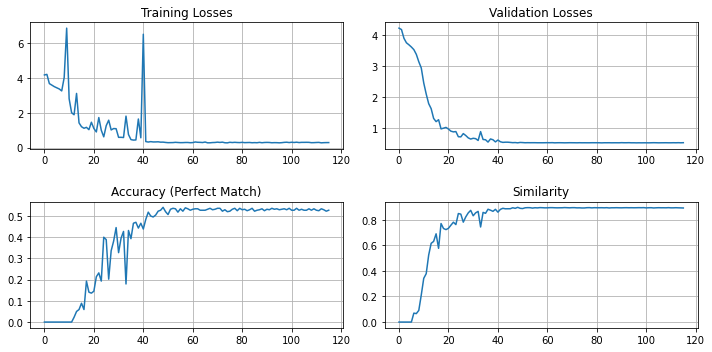

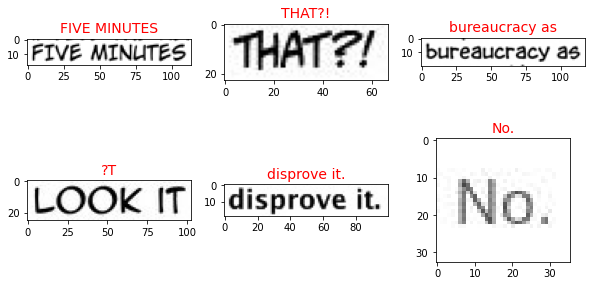

Epoch 24: 100%|██████████| 9321/9321 [00:20<00:00, 449.72it/s, current_batch_loss=0.211] 


In [41]:
_ = train.train(
    model_name, model,
    train_dataset=training_dataset,
    train_device=device,
    validate_dataset=validation_dataset,
    validate_device=device,
    update_callback=save_and_report,
    update_every_n=40,
    batch_size=50,
    train_epoch_count=25)

<Figure size 720x360 with 0 Axes>

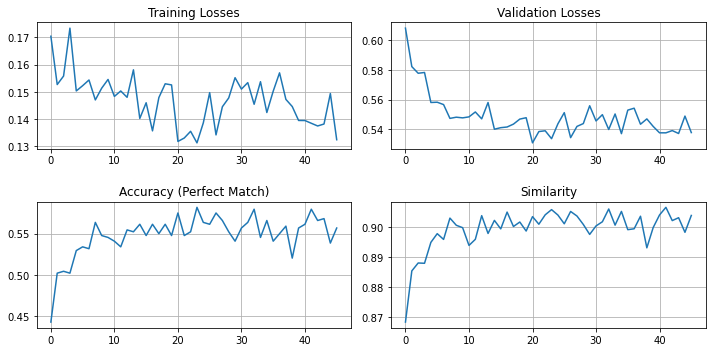

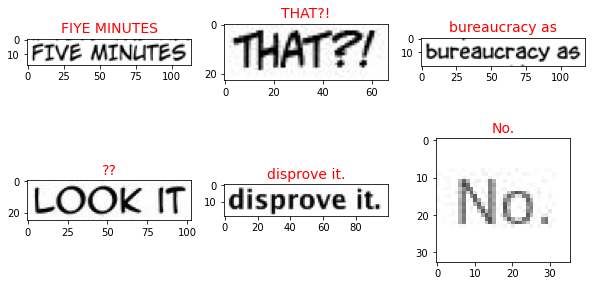

Epoch 19: 100%|██████████| 464/464 [00:07<00:00, 59.11it/s, current_batch_loss=0.021]  


In [42]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, nesterov=True, weight_decay=1e-6, momentum=0.01)

_ = train.train(
    model_name, model,
    train_dataset=final_training_dataset,
    train_device=device,
    validate_dataset=validation_dataset,
    validate_device=device,
    update_callback=save_and_report,
    update_every_n=200,
    batch_size=1,
    train_epoch_count=20,
    optimizer=optimizer)

# Validationfrom

In [43]:
from comic_ocr.models import recognition
from comic_ocr.models import localization
from comic_ocr.utils import image_with_annotations
from comic_ocr.utils.plotting import show_images


In [44]:
localization_model = localization.load_model()


# default_model = recognition.load_model()
model = recognition.load_model(model_path)

In [45]:
dataset_example_path = get_path_project_dir('example/manga_annotated')
dataset_example = recognition.RecognitionDataset.load_annotated_dataset(dataset_example_path)


recognition.calculate_high_level_metrics(model, dataset_example, device=device)

{'dataset_size': 40,
 'perfect_match_count': 25,
 'perfect_match_accuracy': 0.625,
 'similarity': 0.9327107794698908}

In [46]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = recognition.RecognitionDataset.load_annotated_dataset(dataset_annotated_path)

recognition.calculate_high_level_metrics(model, dataset_annotated, device=device)

{'dataset_size': 824,
 'perfect_match_count': 534,
 'perfect_match_accuracy': 0.6480582524271845,
 'similarity': 0.9259448655134249}

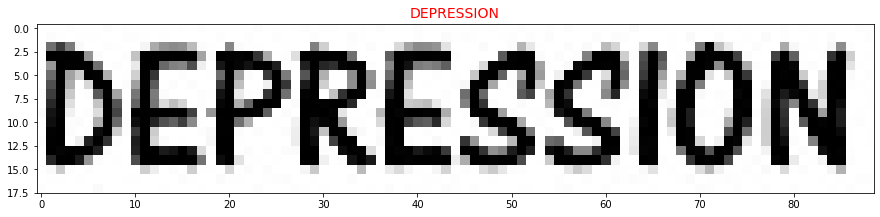

In [47]:
show_images(
    [dataset_example.get_line_image(0)],
    [model.recognize(dataset_example.get_line_image(0), device=device)],
) 

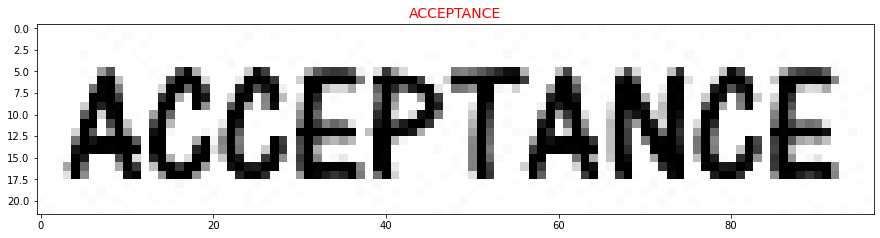

In [48]:
show_images(
    [dataset_example.get_line_image(1)],
    [model.recognize(dataset_example.get_line_image(1), device='cpu')],
) 